# Installs

In [ ]:
!pip install rouge-score
!pip uninstall -y wandb

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cf71549e540e67432f534cdab9bbf1ba2b217450f65b8624c0ca9c6b3e702980
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 11.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 93.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Libraries

In [ ]:
import re
import ast
import torch
import tokenizers
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer, MT5ForConditionalGeneration, MT5Tokenizer, EarlyStoppingCallback

# Reading Data

In [ ]:

df_tydiqa = pd.read_csv('/kaggle/input/tydiqa-data/tydiqa-arabic.csv')
print("tydiqa data loaded")

# Data Overview

In [4]:
df_tydiqa.head()

,id,question,context,answers,c_id
0,arabic-2387335860751143628-1,كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...,أقيمت البطولة 21 مرة، شارك في النهائيات 78 دول...,"[{'text': 'بطولتين', 'answer_start': 394}]",0
1,arabic--3358420169913421088-0,من هو مكتشف المرو أو الكوارتز ؟,المرو أو الكوارتز هو معدن يعود اكتشافه إلى ال...,"[{'text': '(بيير كوري) وأخوه (جاك)', 'answer_s...",1
2,arabic-6869798435672288559-0,كيف يتصل الجنين بالرحم ؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,"[{'text': 'عن طريق الحبل السري', 'answer_start...",2
3,arabic-1608369850259830544-0,ما هي المَشِيمَة أو الخَلاَص أو السُخْد؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,[{'text': 'عضو دائري مسطح الشكل يتصل بالجنين ع...,2
4,arabic--7165672200361826550-0,أين يقع مسجد السلطان عبد المجيد؟,مسجد السلطان عبد المجيد، هو مسجد أثري تاريخي ف...,"[{'text': 'مدينة جبيل اللبنانية', 'answer_star...",3


In [5]:
df_tydiqa.shape

(921, 5)

In [6]:
df_tydiqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        921 non-null    object
 1   question  921 non-null    object
 2   context   921 non-null    object
 3   answers   921 non-null    object
 4   c_id      921 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 36.1+ KB


# Removing id column

In [7]:
df_tydiqa.drop('id', axis=1, inplace=True)

In [8]:
df_tydiqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  921 non-null    object
 1   context   921 non-null    object
 2   answers   921 non-null    object
 3   c_id      921 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


In [9]:
df_tydiqa.head(10)

,question,context,answers,c_id
0,كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...,أقيمت البطولة 21 مرة، شارك في النهائيات 78 دول...,"[{'text': 'بطولتين', 'answer_start': 394}]",0
1,من هو مكتشف المرو أو الكوارتز ؟,المرو أو الكوارتز هو معدن يعود اكتشافه إلى ال...,"[{'text': '(بيير كوري) وأخوه (جاك)', 'answer_s...",1
2,كيف يتصل الجنين بالرحم ؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,"[{'text': 'عن طريق الحبل السري', 'answer_start...",2
3,ما هي المَشِيمَة أو الخَلاَص أو السُخْد؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,[{'text': 'عضو دائري مسطح الشكل يتصل بالجنين ع...,2
4,أين يقع مسجد السلطان عبد المجيد؟,مسجد السلطان عبد المجيد، هو مسجد أثري تاريخي ف...,"[{'text': 'مدينة جبيل اللبنانية', 'answer_star...",3
5,ما عاصمة جورجيا؟,رغم سيطرة المسلمين على العاصمة تبليسي في 645 م...,"[{'text': 'تبليسي', 'answer_start': 31}]",4
6,ما هي عاصمة جورجيا؟,رغم سيطرة المسلمين على العاصمة تبليسي في 645 م...,"[{'text': 'تبليسي', 'answer_start': 31}]",4
7,ما هو عدد آيات سورة الكهف ؟,سورة الكهف هي سورةٌ مكيةٌ رقمها 18، تسبق سورة ...,"[{'text': '110', 'answer_start': 110}, {'text'...",5
8,ما سبب وفاة لاعب كمال الأجسام ناصر السنباطي؟,توفي ناصر السنباطي يوم 20 مارس 2013 في القاهرة...,"[{'text': 'أثناء نومه', 'answer_start': 84}]",6
9,من هو مخترع المحرك البخاري؟,مخترع المحرك البخاري هو جيمس واط (1736 – 1819م...,"[{'text': 'جيمس واط', 'answer_start': 24}]",7


# Text Preprocessing

## text cleaning functions

### Normalization

In [10]:
def remove_diacritics(text):
    # remove diacritics from the text as it may confuse the model
    return re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)


### Text cleaning

In [11]:
def remove_non_arabic(text):
    # Remove non-Arabic characters, keeping essential punctuation
    text = re.sub(r'[^\u0600-\u06FF\s؟]', '', text)
    return text

In [27]:
def remove_punk(text):
    # Remove punctuation
    arabic_punctuation = r'[،؛…!"#$%&\'()*+,-./:;<=>@^_`{|}~]'
    text = re.sub(arabic_punctuation, '', text)
    return text

In [13]:
def remove_extra_spaces(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [14]:
def remove_alef_variations(text):
    text = re.sub(r'[إأٱآ]', 'ا', text)
    return text

### Handling numbers

In [15]:
def handle_numbers(text, replace_with=None):
    if replace_with:
        text = re.sub(r'\d+', replace_with, text)
    else:
        text = re.sub(r'\d+', '', text)
    return text

## Stop word removal

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
stop_words = set(stopwords.words('arabic'))
print(stop_words)

{'إى', 'تسعين', 'تسعمائة', 'أضحى', 'كن', 'حسب', 'نفس', 'والذين', 'خمسين', 'آض', 'أنتم', 'لئن', 'غداة', 'بس', 'يوليو', 'كيف', 'أما', 'إليكم', 'وا', 'إيانا', 'ثلاثين', 'يمين', 'آه', 'من', 'هذي', 'قلما', 'مه', 'ذيت', 'أصلا', 'عل', 'آب', 'مكانكما', 'غين', 'أنتن', 'أرى', 'قرش', 'خلا', 'سبعمئة', 'حار', 'ومن', 'على', 'أو', 'خمس', 'لعلَّ', 'أولالك', 'دواليك', 'درى', 'كل', 'عليك', 'لكي', 'لسن', 'آهِ', 'كلما', 'كأيّ', 'فلا', 'لكنَّ', 'خمسمائة', 'بخٍ', 'أمد', 'واحد', 'هلم', 'تسعمئة', 'تموز', 'ر', 'أعلم', 'حيثما', 'سبتمبر', 'بلى', 'آذار', 'ج', 'اللذين', 'أربعمئة', 'أم', 'كذلك', 'رزق', 'لمّا', 'مكانَك', 'لكنما', 'كذا', 'هَذا', 'سبحان', 'استحال', 'حمٌ', 'تشرين', 'مساء', 'عشرة', 'غ', 'هَاتِه', 'له', 'إلا', 'بعض', 'ثم', 'شمال', 'أى', 'ى', 'وما', 'شين', 'هلا', 'هما', 'حاشا', 'يفعلون', 'لستما', 'هاء', 'أبريل', 'فوق', 'أول', 'عدا', 'لعل', 'وَيْ', 'ياء', 'هيّا', 'إزاء', 'إذ', 'جنيه', 'تخذ', 'مازال', 'خامس', 'رويدك', 'تفعلين', 'بسّ', 'أمام', 'ألا', 'نعم', 'ئ', 'ذَيْنِ', 'ش', 'بكما', 'ل', 'الآن', 'زود', 'لا

In [18]:
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Sentence splitting

In [19]:
def split_sentences(text):
    sentences = re.split(r'[؟.!؟]', text)
    # Remove empty sentences and strip spaces
    return [sentence.strip() for sentence in sentences if sentence.strip()]

## Remove additional spaces between letters

In [20]:
def fix_arabic_spacing(text):
    # Reconnect ا to the previous word if it is fully isolated
    text = re.sub(r'(\S)\s+ا\s+', r'\1ا ', text)

    # Reconnect أ and ي to the next word if they are fully isolated
    text = re.sub(r'\s+أ\s+(\S)', r' أ\1', text)
    text = re.sub(r'\s+ي\s+(\S)', r' ي\1', text)

    # Normalize spaces (remove extra spaces)
    text = remove_extra_spaces(text)

    return text

![image.png](attachment:image.png)

# Tokenization

In [23]:
!pip install SentencePiece 
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


### Selected tokenizer

In [24]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Apply Functions on the text

In [25]:
df_tydiqa.head(10)


,question,context,answers,c_id
0,كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...,أقيمت البطولة 21 مرة، شارك في النهائيات 78 دول...,"[{'text': 'بطولتين', 'answer_start': 394}]",0
1,من هو مكتشف المرو أو الكوارتز ؟,المرو أو الكوارتز هو معدن يعود اكتشافه إلى ال...,"[{'text': '(بيير كوري) وأخوه (جاك)', 'answer_s...",1
2,كيف يتصل الجنين بالرحم ؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,"[{'text': 'عن طريق الحبل السري', 'answer_start...",2
3,ما هي المَشِيمَة أو الخَلاَص أو السُخْد؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,[{'text': 'عضو دائري مسطح الشكل يتصل بالجنين ع...,2
4,أين يقع مسجد السلطان عبد المجيد؟,مسجد السلطان عبد المجيد، هو مسجد أثري تاريخي ف...,"[{'text': 'مدينة جبيل اللبنانية', 'answer_star...",3
5,ما عاصمة جورجيا؟,رغم سيطرة المسلمين على العاصمة تبليسي في 645 م...,"[{'text': 'تبليسي', 'answer_start': 31}]",4
6,ما هي عاصمة جورجيا؟,رغم سيطرة المسلمين على العاصمة تبليسي في 645 م...,"[{'text': 'تبليسي', 'answer_start': 31}]",4
7,ما هو عدد آيات سورة الكهف ؟,سورة الكهف هي سورةٌ مكيةٌ رقمها 18، تسبق سورة ...,"[{'text': '110', 'answer_start': 110}, {'text'...",5
8,ما سبب وفاة لاعب كمال الأجسام ناصر السنباطي؟,توفي ناصر السنباطي يوم 20 مارس 2013 في القاهرة...,"[{'text': 'أثناء نومه', 'answer_start': 84}]",6
9,من هو مخترع المحرك البخاري؟,مخترع المحرك البخاري هو جيمس واط (1736 – 1819م...,"[{'text': 'جيمس واط', 'answer_start': 24}]",7


### Questions column

In [35]:
df_tydiqa['processed_question'] = df_tydiqa['question'].apply(remove_diacritics).apply(remove_punk).apply(remove_extra_spaces)

* i tried to apply text clean function but i think it made some question not understandable

In [36]:
df_tydiqa['processed_question'].head(10)

0    كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...
1                      من هو مكتشف المرو أو الكوارتز ؟
2                             كيف يتصل الجنين بالرحم ؟
3                    ما هي المشيمة أو الخلاص أو السخد؟
4                     أين يقع مسجد السلطان عبد المجيد؟
5                                     ما عاصمة جورجيا؟
6                                  ما هي عاصمة جورجيا؟
7                          ما هو عدد آيات سورة الكهف ؟
8         ما سبب وفاة لاعب كمال الأجسام ناصر السنباطي؟
9                          من هو مخترع المحرك البخاري؟
Name: processed_question, dtype: object

### Context column

In [42]:
# remove punctuation from words
df_tydiqa['processed_context'] = df_tydiqa['context'].apply(remove_punk).apply(remove_diacritics).apply(remove_extra_spaces)

In [43]:
df_tydiqa['processed_context'][df_tydiqa['c_id'] == 543].tolist()[0]

'المنمنمة الفارسية هي لوحة أو صورة صغيرة الحجم إما تستخدم كتوضيح في كتاب أو تكون عملا فنيا مستقلا بذاته المنمنمات الفارسية كانت ذات تأثير مسيطر على جميع النسخ الأخرى من المنمنمات الإسلامية خصوصا المنمنمات العثمانية في تركيا والمنمنمات المغولية في الهند أصبحت المنمنمات الفارسية ذات طابع وثيق بالثقافة الإسلامية بعدما ركزت على تصوير معالم ومظاهر إسلامية أو تصوير خلفاء وقادة إسلاميون'

### Answers column

In [44]:
def extract_text(data):
    if isinstance(data, str):  # If data is a string, convert it to a list
        try:
            data = ast.literal_eval(data)  # Convert string to actual list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None

    if isinstance(data, list) and data:  # Check if it's a valid non-empty list
        first_item = data[0]  # Access the first dictionary
        if isinstance(first_item, dict):  # Ensure it's a dictionary
            return first_item.get('text', None)  # Get the 'text' value or None if not found
    return None

In [45]:
df_tydiqa['processed_answers'] = df_tydiqa['answers'].apply(extract_text)

In [46]:
df_tydiqa['processed_answers'] = df_tydiqa['processed_answers'].apply(remove_diacritics).apply(remove_extra_spaces).apply(remove_punk)

In [47]:
df_tydiqa.head()

,question,context,answers,c_id,processed_question,processed_context,processed_answers
0,كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...,أقيمت البطولة 21 مرة، شارك في النهائيات 78 دول...,"[{'text': 'بطولتين', 'answer_start': 394}]",0,كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...,أقيمت البطولة 21 مرة شارك في النهائيات 78 دولة...,بطولتين
1,من هو مكتشف المرو أو الكوارتز ؟,المرو أو الكوارتز هو معدن يعود اكتشافه إلى ال...,"[{'text': '(بيير كوري) وأخوه (جاك)', 'answer_s...",1,من هو مكتشف المرو أو الكوارتز ؟,المرو أو الكوارتز هو معدن يعود اكتشافه إلى الف...,بيير كوري وأخوه جاك
2,كيف يتصل الجنين بالرحم ؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,"[{'text': 'عن طريق الحبل السري', 'answer_start...",2,كيف يتصل الجنين بالرحم ؟,المشيمة أو الخلاص أو السخد بالإنجليزية Placent...,عن طريق الحبل السري
3,ما هي المَشِيمَة أو الخَلاَص أو السُخْد؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,[{'text': 'عضو دائري مسطح الشكل يتصل بالجنين ع...,2,ما هي المشيمة أو الخلاص أو السخد؟,المشيمة أو الخلاص أو السخد بالإنجليزية Placent...,عضو دائري مسطح الشكل يتصل بالجنين عن طريق الحب...
4,أين يقع مسجد السلطان عبد المجيد؟,مسجد السلطان عبد المجيد، هو مسجد أثري تاريخي ف...,"[{'text': 'مدينة جبيل اللبنانية', 'answer_star...",3,أين يقع مسجد السلطان عبد المجيد؟,مسجد السلطان عبد المجيد هو مسجد أثري تاريخي في...,مدينة جبيل اللبنانية


In [48]:
df_tydiqa.to_excel("tydiqa_data_processed.xlsx", index=False, engine="openpyxl")  # Save as Excel

# Prepare the data for Train

## load data

In [10]:
df_tydiqa = pd.read_excel("/kaggle/input/arabic-squad-processed/Arabic_squad_data_processed.xlsx")

## tokenizer

In [49]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

### T5 preparation

In [51]:
def preprocess_dataset(dataset):
    preprocessed_data = []
    skip_counter = 0
    answer_skiped_counter = 0
    for example in dataset:
        
        # Skip empty examples
        if not example["processed_context"] or not example["processed_question"] or not example["processed_answers"]:
            skip_counter += 1
            continue

        # Tokenize the input (context)
        inputs = tokenizer(
            example["processed_context"],
            max_length=256,
            truncation=True,
            padding="max_length",
        )

        # # Ensure answers are not empty and get the first answer
        # if isinstance(example["processed_answers"], list) and example["processed_answers"]:
        #     answer_text = example["processed_answers"][0]
        # else:
        #     answer_skiped_counter += 1
        #     answer_text = ""
            
        # answer_text = example["processed_answers"][0] if isinstance(example["processed_answers"], list) and example["processed_answers"] else ""
        # answer_text = example["processed_answers"]
        # answer_text = ""
        
        # Combine question and answer for label (question generation + answer)
        question_answer_text = example["processed_question"]

        # Tokenize the target (question)
        labels = tokenizer(
            question_answer_text,
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # Append preprocessed data
        preprocessed_data.append({
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels["input_ids"], dtype=torch.long),
        })
        
    print(skip_counter , " skiped due to empty")
    print(answer_skiped_counter , " answers skiped")
    return preprocessed_data


![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [52]:
# Split by context_id to avoid data leakage
context_ids = df_tydiqa["c_id"].unique()
train_ids, test_ids = train_test_split(context_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Create splits
train_data = df_tydiqa[df_tydiqa["c_id"].isin(train_ids)].to_dict("records")
val_data = df_tydiqa[df_tydiqa["c_id"].isin(val_ids)].to_dict("records")
test_data = df_tydiqa[df_tydiqa["c_id"].isin(test_ids)].to_dict("records")

# Preprocess each split
train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)


print("total rows after processing ", len(train_processed) + len(val_processed) + len(test_processed))

0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
total rows after processing  921


# Model

### Select a model

In [71]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5-local")

### Change the size of the model to accept the tokens

In [72]:
# Resize the model's embedding layer
model.resize_token_embeddings(len(tokenizer))

# Verify the new vocabulary size
print("New model vocabulary size:", model.config.vocab_size)

New model vocabulary size: 110100


## check on data

In [73]:
def check_tensor_dataset(dataset, name="Dataset"):
    print(f"Checking {name} for NaN or Inf values...")
    for i in range(len(dataset)):
        sample = dataset[i]  # Get one example (which is a dictionary)

        for key in ["input_ids", "attention_mask", "labels"]:
            if key in sample:
                tensor = sample[key]  # Extract tensor for this key

                if torch.isnan(tensor).any():
                    print(f"NaN found in {key} at index {i}")
                if torch.isinf(tensor).any():
                    print(f"Inf found in {key} at index {i}")

    print(f"Check complete for {name}.\n")

In [74]:
check_tensor_dataset(train_data, "Training Dataset")

Checking Training Dataset for NaN or Inf values...
Check complete for Training Dataset.



In [75]:
check_tensor_dataset(val_data, "Validation Dataset")

Checking Validation Dataset for NaN or Inf values...
Check complete for Validation Dataset.



In [76]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)  # Get predictions (argmax for classification)
    acc = accuracy_score(labels, preds)  # Compute accuracy
    return {"accuracy": acc}  # Return accuracy

## Train the model

In [81]:
# Define training arguments
num_train_epochs = 15

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=num_train_epochs,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=False,
    fp16=False,
    dataloader_num_workers=2,
    save_safetensors=False,  # Add this line
)

# Create a Trainer instance with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
)

# Train the model with logging
print("Starting training...")
trainer.train()
print("Training completed.")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.182400,0.110598
2,0.177100,0.103264
3,0.102600,0.103016
4,0.080000,0.099261
5,0.104500,0.099438
6,0.066900,0.099612
7,0.061100,0.101205
8,0.062700,0.101873
9,0.061600,0.102341
10,0.053000,0.104181


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Training completed.


# Test 

In [82]:
# After training, generate predictions:
input_context = 'ولد العالم العربي الشهير ابن الهيثم في مدينة البصرة عام 965 ميلادي. كان أحد أبرز العلماء في العصر الذهبي الإسلامي، حيث قدم مساهمات كبيرة في مجالات البصريات، والرياضيات، والهندسة، والفيزياء. يُعتبر كتابه "المناظر" من أهم الكتب التي أثرت في علم البصريات، حيث شرح فيه مبادئ الانعكاس والانكسار، ووضع أسس علم الضوء الحديث. بالإضافة إلى ذلك، كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي، إذ اعتمد على الملاحظة والتجربة لإثبات نظرياته. سافر إلى مصر بدعوة من الخليفة الفاطمي الحاكم بأمر الله، وهناك قام بدراسة سلوك الضوء في الماء والهواء.'

# Tokenize the context and move to the same device as the model
inputs = tokenizer(input_context, return_tensors="pt").to("cuda")

for i in range(4):
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            # num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.8,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )
    
    # Decode the output ids to text
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Text {i+1}-{j+1}:", generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Text 1-1: متى ولد ابن الهيثم ؟
Generated Text 1-2: متى ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 1-3: متى ولد ابن الهيثم؟
Generated Text 1-4: متى ولد العالم ابن الهيثم؟
Generated Text 2-1: متى ولد العالم العربي ابن الهيثم؟
Generated Text 2-2: متى ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 2-3: متى ولد العالم العربي ابن الهيثم؟
Generated Text 2-4: متى ولد العالم العربي ابن الهيثم؟
Generated Text 3-1: متى ولد ابن الهيثم؟
Generated Text 3-2: متى ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 3-3: متى ولد العالم العربي ابن الهيثم؟
Generated Text 3-4: متى ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 4-1: متى ولد العالم العربي ابن الهيثم؟
Generated Text 4-2: متى ولد ابن الهيثم؟
Generated Text 4-3: متى ولد ابن الهيثم؟
Generated Text 4-4: متى ولد العالم العربي الشهير ابن الهيثم؟


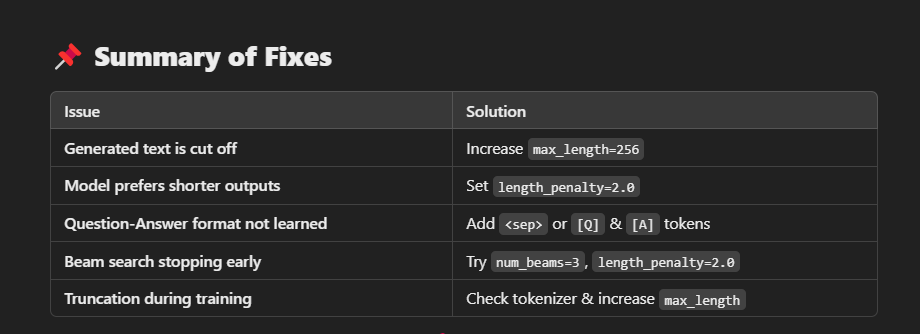

In [85]:
predictions = []
true_labels = []
contexts = []
device = "cuda"
for example in test_processed[20:40]:
    input_ids = example["input_ids"].unsqueeze(0).to(device)
    attention_mask = example["attention_mask"].unsqueeze(0).to(device)

    # Decode the input context
    context_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    contexts.append(context_text)

    # Extract the true label (ground truth)
    true_label_ids = example["labels"]
    true_label_text = tokenizer.decode(true_label_ids, skip_special_tokens=True)
    true_labels.append(true_label_text)

    # Generate prediction
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=512,
            do_sample = True,
            # num_beams=5,
            # length_penalty=2.0,  # Increase length preference
            top_p = 0.9,
            temperature = 0.7,
            num_return_sequences = 5,
            early_stopping=True
        )

    predicted_text = tokenizer.decode(output_ids[0], skip_special_tokens=True) # try False
    predictions.append(predicted_text)

# Print some sample results
for i, (context, pred, true) in enumerate(zip(contexts[:], predictions[:], true_labels[:])):
    print(f"Example {i+1}:")
    print(f"  Context (Input): {context}")
    print(f"  Prediction: {pred}")
    print(f"  Ground Truth: {true}")
    print("------------")

# Compute BLEU score
bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_labels, predictions)]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"BLEU Score: {average_bleu:.4f}")

Example 1:
  Context (Input): مات المستشار الألماني أدولف هتلر في 30 أبريل 1945 منتحرا عن طريق تناول مادة السيانيد السامة وإطلاق النار على نفسه وهي الرواية العامة المقبولة لطريقة موت الزعيم النازي ولكن هذه الطريقة المزدوجة في الانتحار والظروف الأخرى التي أحاطت بالحادثة شجعت البعض على إطلاق الشائعات بأن هتلر لم ينتحر وأنه عاش حتى نهاية الحرب العالمية الثانية مع الاختلاف حول ما حدث لجثته وقد أكدت الوثائق السوفيتية المفرج عنها من جهازي كي جي بي وجهاز الأمن الفيدرالي الروسي سنة 1993 الرواية التي تقول بانتحاره ولكنها لم تظهر ما حدث لبقايا جثته بعد حرقها
  Prediction: متى انتحر أدولف هتلر؟
  Ground Truth: متى توفي هتلر؟
------------
Example 2:
  Context (Input): نهر ليمبوبو أحد أكبر الأنهار في أفريقيا بعد نهر زمبيزي والتي تصب في المحيط الهندي ومصدر هذا النهر من جنوب وسط أفريقيا ويجري بصورة عامة باتجاه الشرق حتى مصبه في المحيط الهندي يبلغ طول النهر حوالي 1750 كيلومتر ومساحة حجم حوض تصريفه 415000 كيلومتر مربع ومعدل تصريفه السنوي 170 متر مكعب في الثانية 6200 قدم مكعب في الثانية [1] ويجري هذا ال